<a href="https://colab.research.google.com/github/PadmarajBhat/Machine-Learning/blob/master/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of 3 Brain Tumors (Meningioma, Glioma and Pituitary) in T1-weighted contrast enhanced images

### - Revisitng the Udacity Capstone Project in pursuit of better accuracy



# What is the problem statement?
  * predict the tumor class given a MRI image
  * OR predict the tumor class when both MRI and Tumor region is given !!!
      * tumor region is identified and put in input dataset by experts
          * can we have Image Segmentation problem ?


  * I think this is the order of problem from easy level to difficult level
    * Identify the tumor class from raw MRI image (here accuracy may be low)
    * Identify the tumor class from raw MRI image with tumor region identified info (here accuracy may be better)
    * Auto detect the tumor segment in a MRI image and classify the tumor (ideal application for a radiologist)

    Let us try all the 3 !!!

# Import Packages
* read the input MRI images (.mat) files through ***h5py***
* **bokeh** plot for the zoomed in analysis of a tumor and neighbors
* ***pandas*** for data analysis and preprocessing
* ***tensorflow*** for modelling and predicting

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import os
import zipfile
import h5py
import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

import imageio
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random # for radom selection from a list



In [4]:
tf.__version__

'2.0.0-rc2'

In [0]:
# a Global variable
tumor_names = ["","Meningioma","Glioma","Pituitary"]

# Load Data

* **Iteration 1**:
    * Mount Google Drive
    * Unzip it in colab disk
    * load mat attributes to list of tuples ( with mri and tumor 5 point summary details)
    * create a panda dataframe for analysis

    ##### Issues Faced:
    1. loading to panda with image took half(6GB) of RAM
    * loading tumor along with mri image (as in mat file) crashed the colab
      * Solution: let us load image but save only 5 point summary for both mri image and tumor

    2. How do we scale/normalize the data?
      * would tumor region have 0 in it ?
        * only way to know is through the value present in the binary indicator == 1
            * implementation through 2 for loops takes forever !!!
              * need to implement throuhg np.where...a[a == 1] !!!
            

    3. Some images are less than 512
        * pad the difference with 0s.
        
    4. Should tumor image be scaled between 0 -1? For now, brightness values are relative to that of the whole image to which it belongs to.

    5. Epoch run failed due to no data generated by the custom generator.
      * Going to try the ImageGenerator from the TF.


* **Iteration 2** :
  * ImageGenerator worked fine but the np to image conversion had used dtype of np.uint8 to avoid warning during saving to image. However, that lead to corrupt image and hence loss was more and accuracy was less.
  * Generator built for the iteration is correct ?
      * are *flips* is not damaging data

* **Iteration 3** :
  * validate the image augmentation in the ImageGenerator
  * initial load the data was fine. zip based train and test failed

* **Iteration 4**:
  * open all mat(hdf5) files and load 5 point summary of mri and tumor to a panda df
  * save all the numpy mri image array to training_data directory
  * split the df to training : testing = 80 :20
  * move the 20% of the testing to testing_data
  * out of the 80% training data, move the 10% for the validation during training
      * download
        * 5
        * b*.zip
        * *.txt
        * mat
          * *.mat

      * training_data
        * 1
          * *.npy
        * 2
          *  *.npy
        * 3
          * *.npy
      * validation_data
        * 1
          * *.npy
        * 2
          *  *.npy
        * 3
          * *.npy
      * testing_data
        * 1
          * *.npy
        * 2
          *  *.npy
        * 3
          * *.npy


  

from google.colab import drive
drive.mount('/content/drive')

##### Google Drive File Check

In [6]:
def loadMatFiles(dir="training_data/"):
  if not os.path.isfile("download/mat/1.mat"):
    cmds = [
            "rm -rf download data training_data testing_data"
            ,"wget https://ndownloader.figshare.com/articles/1512427/versions/5 -P download"
            ,"unzip download/5 -d download"
            ,"unzip -q download/brainTumorDataPublic_1-766.zip -d download/mat"
            ,"unzip -q download/brainTumorDataPublic_1533-2298.zip -d download/mat"
            ,"unzip -q download/brainTumorDataPublic_767-1532.zip   -d download/mat"
            ,"unzip -q download/brainTumorDataPublic_2299-3064.zip  -d download/mat"]

    for c in cmds:
      os.system(c)
  else:
    print("mat files are loaded into download/mat directory")

def loadTraininData():
  os.system("mkdir training_data training_data/1 training_data/2 training_data/3")
  if not len(os.listdir("training_data/1")):
    for file_name in os.listdir("download/mat"):
      with h5py.File("download/mat/"+file_name,'r') as f:
        mri_image = np.array(f['cjdata']['image'],dtype=np.int16)
        label = np.array(f['cjdata']['label'], dtype=np.int)[0][0]
        imageio.imwrite("training_data/"+str(label)+"/"+file_name.split(".")[0]+'.jpg', mri_image)


def loadTrainingData():
  os.system("mkdir training_data training_data/1 training_data/2 training_data/3")
  if not len(os.listdir("training_data/1")):
    for file_name in os.listdir("download/mat"):
      with h5py.File("download/mat/"+file_name,'r') as f:
        mri_image = np.array(f['cjdata']['image'],dtype=np.int16)
        label = np.array(f['cjdata']['label'], dtype=np.int)[0][0]
        imageio.imwrite("training_data/"+str(label)+"/"+file_name.split(".")[0]+'.jpg', mri_image)

def loadTestingData():
  os.system("mkdir testing_data testing_data/1 testing_data/2 testing_data/3")
  
  for i in range(1,4):
      if not len(os.listdir("testing_data/"+str(i))):
        files = os.listdir("training_data/"+str(i))
        for file in random.choices(files,k=round(len(files)*.2)):
          try:
            os.rename("training_data/"+str(i)+"/"+file, "testing_data/"+str(i)+"/"+file)
          except:
            print("Ignoring ", file)

def loadValidationData():
  os.system("mkdir validation_data validation_data/1 validation_data/2 validation_data/3")
  
  for i in range(1,4):
      if not len(os.listdir("validation_data/"+str(i))):
        files = os.listdir("training_data/"+str(i))
        for file in random.choices(files,k=round(len(files)*.1)):
          try:
            os.rename("training_data/"+str(i)+"/"+file, "validation_data/"+str(i)+"/"+file)
          except:
            print("Ignoring ", file)


loadMatFiles()
loadTrainingData()
loadTestingData()
loadValidationData()

Ignoring  376.jpg
Ignoring  394.jpg
Ignoring  435.jpg
Ignoring  516.jpg
Ignoring  697.jpg
Ignoring  385.jpg
Ignoring  97.jpg
Ignoring  465.jpg
Ignoring  363.jpg
Ignoring  159.jpg
Ignoring  2505.jpg
Ignoring  1986.jpg
Ignoring  2112.jpg
Ignoring  2416.jpg
Ignoring  2322.jpg
Ignoring  2206.jpg
Ignoring  2492.jpg
Ignoring  734.jpg
Ignoring  1884.jpg
Ignoring  2416.jpg
Ignoring  2577.jpg
Ignoring  2011.jpg
Ignoring  828.jpg
Ignoring  876.jpg
Ignoring  2551.jpg
Ignoring  2250.jpg
Ignoring  2569.jpg
Ignoring  2096.jpg
Ignoring  857.jpg
Ignoring  2648.jpg
Ignoring  788.jpg
Ignoring  2762.jpg
Ignoring  2152.jpg
Ignoring  778.jpg
Ignoring  1061.jpg
Ignoring  1528.jpg
Ignoring  937.jpg
Ignoring  1296.jpg
Ignoring  1093.jpg
Ignoring  1692.jpg
Ignoring  1018.jpg
Ignoring  1223.jpg
Ignoring  1736.jpg
Ignoring  1708.jpg
Ignoring  1029.jpg
Ignoring  1287.jpg
Ignoring  1105.jpg
Ignoring  1268.jpg
Ignoring  1402.jpg
Ignoring  1803.jpg
Ignoring  539.jpg
Ignoring  180.jpg
Ignoring  624.jpg
Ignoring  681.

### Load Image Array

def retrieveImage(file_name):
  f = h5py.File(file_name,'r')
  mri_image = np.array(f['cjdata']['image'],dtype=np.float64)
  if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
  return mri_image/mri_image.max()

### Load Tumor Array

def retrieveTumorImage(file_name):
  f = h5py.File(file_name,'r')
  mri_image = np.array(f['cjdata']['tumorMask'],dtype=np.float128)
  if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
  return mri_image/mri_image.max()

### Create Directories for ImageGenerator

!mkdir "training_data/images/"
!mkdir "training_data/images/1"
!mkdir "training_data/images/2"
!mkdir "training_data/images/3"

!mkdir "testing_data/images/"
!mkdir "testing_data/images/1"
!mkdir "testing_data/images/2"
!mkdir "testing_data/images/3"

### Load Image and Tumor Statistics to Panda

*   Panda df would have 5 point summary of both mri and tumor
*   data directory will have label wise subdirectories for ImageGenerator



def return_imageInfo_from_mat_file(dir,file_name):
    f = h5py.File(dir+file_name,'r')

    mri_image = np.array(f['cjdata']['image'],dtype=np.float128)
    #scaler = MinMaxScaler(feature_range=(1,2))
    #mri_image = scaler.fit(mri_image)
    mri_image = mri_image/mri_image.max()

    if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
    
    temp_mri_image = np.copy(mri_image)
    temp_mri_image[temp_mri_image == 0 ] = 2

    mri_quartiles = np.percentile(mri_image[mri_image > 0], [25, 50, 75,80,85,90,95,96,97,98,99])

    tumor_image = np.array(f['cjdata']['tumorMask'], dtype=np.float128)
    if tumor_image.shape[0] < 512:
      print("Shape of the tumor image : ", tumor_image.shape)
      tumor_image = np.pad(tumor_image,(512 - tumor_image.shape[0])//2,'constant',constant_values=0)
    
    tumor_image = temp_mri_image * tumor_image
    tumor_image = tumor_image[tumor_image > 0]
    tumor_image[tumor_image == 2] = 0

    '''tumor_array =[]
    for i in range(0,512):
      for j in range(0,512):
        if tumor_image[i][j]:
          tumor_array.append(mri_image[i][j])

    tumor_image = np.array(tumor_array, dtype=np.float)'''

    tumor_quartiles = np.percentile(tumor_image, [25, 50, 75,80,85,90,95,96,97,98,99])

    label=np.array(f['cjdata']['label'], dtype=np.int)[0][0]
    imageio.imwrite(dir+"images/"+str(label)+"/"+file_name.split(".")[0]+'.jpg', np.array(f['cjdata']['image'],dtype=np.int16))

    return np.array(f['cjdata']['PID'],dtype=np.int)[0][0] \
            ,mri_image.min() \
            ,mri_image.max() \
            ,mri_quartiles[0] \
            ,mri_quartiles[1] \
            ,mri_quartiles[2] \
            ,mri_quartiles[3] \
            ,mri_quartiles[4] \
            ,mri_quartiles[5] \
            ,mri_quartiles[6] \
            ,mri_quartiles[7] \
            ,mri_quartiles[8] \
            ,mri_quartiles[9] \
            ,mri_quartiles[10] \
            ,tumor_image.min() \
            ,tumor_image.max() \
            ,tumor_quartiles[0] \
            ,tumor_quartiles[1] \
            ,tumor_quartiles[2] \
            ,tumor_quartiles[3] \
            ,tumor_quartiles[4] \
            ,tumor_quartiles[5] \
            ,tumor_quartiles[6] \
            ,tumor_quartiles[7] \
            ,tumor_quartiles[8] \
            ,tumor_quartiles[9] \
            ,tumor_quartiles[10] \
            ,tumor_image.shape \
            ,file_name\
            ,np.array(f['cjdata']['label'], dtype=np.int)[0][0] 

def loadDf(dir="training_data/"):
  patients_details = []
  '''for root, dirs, files in os.walk("/content/drive/My Drive/1512427/", topdown = False):
    for f in files:
      if ".zip" in f:
          file = zipfile.ZipFile(root+f, "r")
          for name in file.namelist():
            file.extract(name,".")
            patients_details.append(return_imageInfo_from_mat_file(name))
          #break
      #break  '''   
  
  for f in getFileNames(dir):
    if ".mat" in f:
      patients_details.append(return_imageInfo_from_mat_file(dir,f))
  mri_col_names = ["mri_min","mri_max","mri_1q","mri_median", "mri_3q","mri_80","mri_85","mri_90","mri_95","mri_96","mri_97","mri_98","mri_99"]
  tumor_col_names = ["t_min","t_max","t_1q","t_median","t_3q","t_80","t_85","t_90","t_95","t_96","t_97","t_98","t_99","tumor_size"]
  col_names = ["pid"] + mri_col_names + tumor_col_names+ ["file_name","label"]
  return pd.DataFrame(patients_details,columns=col_names)


### Load Training Data

df = loadDf()
df["square_shape"] = df.tumor_size.apply(lambda x: np.sqrt(x[0]))
df.sample(20)

### Load Testing Data

df_test = loadDf("testing_data/")
df_test["square_shape"] = df_test.tumor_size.apply(lambda x: np.sqrt(x[0]))
df_test.sample(20)

### Test the loaded data (both Training and Testing Data)

2 samples for  Meningioma


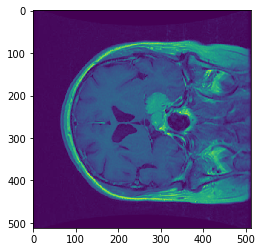

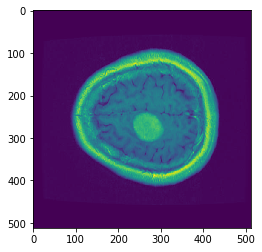

2 samples for  Glioma


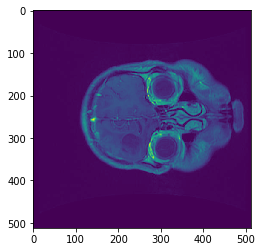

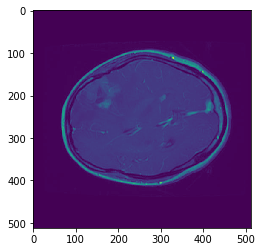

2 samples for  Pituitary


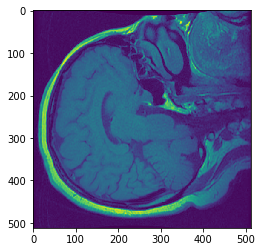

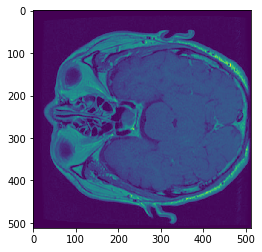

In [7]:
def displayNpImages(dir="training_data/"):
  for i in range(1,4):
    print("2 samples for ",tumor_names[i])
    for j in random.choices( os.listdir(dir+str(i)),k=2):
      plt.imshow(plt.imread(dir+str(i)+"/"+str(j)))
      plt.show()

displayNpImages()

#### Visual Testing Testing Data

2 samples for  Meningioma


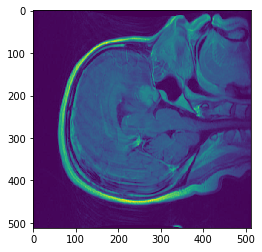

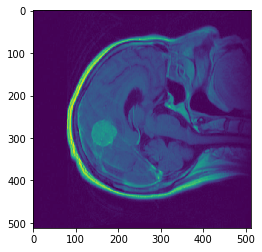

2 samples for  Glioma


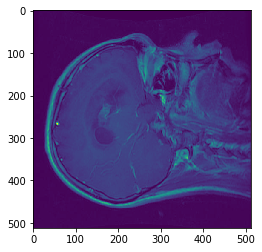

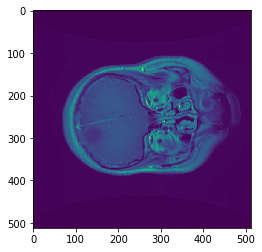

2 samples for  Pituitary


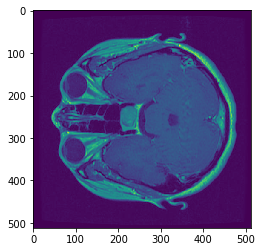

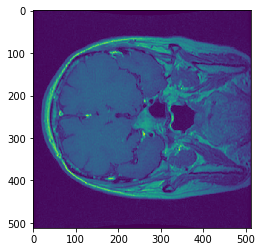

In [8]:
displayNpImages("testing_data/")

2 samples for  Meningioma


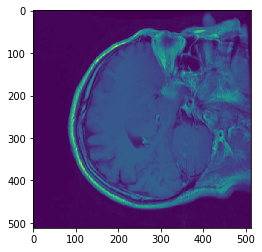

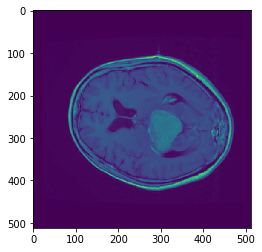

2 samples for  Glioma


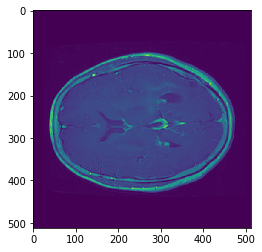

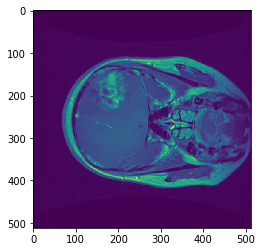

2 samples for  Pituitary


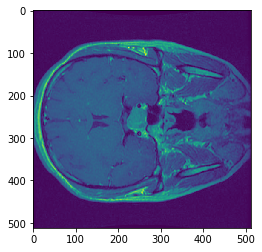

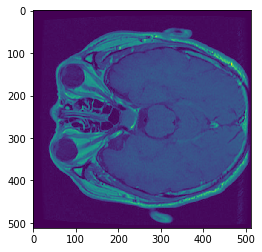

In [9]:
displayNpImages("validation_data/")

def analyzeZipDir(df,start,end):
  df["file_num"] = df.file_name.apply(lambda x: x.split(".")[0])
  df["file_num"] = df.file_num.astype(np.int)
  
  return df[df.file_num.isin(list(range(start,end)))]
analyzeZipDir(df.copy(),1,766).groupby("label").agg("count").reset_index()[["label","pid"]]

analyzeZipDir(df.copy(),1533,2298).groupby("label").agg("count").reset_index()[["label","pid"]]

analyzeZipDir(df_test.copy(),2299,3064).groupby("label").agg("count").reset_index()[["label","pid"]]

analyzeZipDir(df.copy(),767,1532).groupby("label").agg("count").reset_index()[["label","pid"]]

### Create Test directory for validation through generators

!rm -rf "test"
!mkdir "test"
!mkdir "test/1"
!mkdir "test/2"
!mkdir "test/3"

!ls -l /content/data/2/3046.jpg
!ls -l /content/test

!ls -l /content/data/2/2404.jpg

### Move the test set to test directory from data directory

import shutil
import random

for root, dirs, files in os.walk("/content/data", topdown = False):
  
    
    if len(files) > 0:
      print(root, dirs, files)

      #indices = np.random.randint(0,len(files),size=round(len(files)*.2))
      rand_files = random.choices(files,k=round(len(files)*.2))
      
      for f in rand_files:
        #print(f)
        try:
          shutil.move(root+"/"+f, "/content/test/"+root.split("/")[-1]+"/"+f)
        except :
          print("Ignoring : ",f)

#list(os.walk("/content/data")) /content/test /content/training_data

### ImageGenerators

In [26]:
train_datagen = ImageDataGenerator(
        #samplewise_std_normalization=True
        horizontal_flip=True
        ,rescale=1/255
        ,vertical_flip= True)



train_generator = train_datagen.flow_from_directory(
        '/content/training_data',
        target_size=(512,512),
        batch_size=32,
        class_mode='categorical')




validate_datagen = ImageDataGenerator(rescale=1/255)
validate_generator = validate_datagen.flow_from_directory(
        '/content/validation_data',
        target_size=(512,512),
        batch_size=32,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        '/content/testing_data',
        target_size=(512,512),
        batch_size=32,
        class_mode='categorical')


Found 2265 images belonging to 3 classes.
Found 236 images belonging to 3 classes.
Found 563 images belonging to 3 classes.


### Load tf.data
* inspired from: https://stackoverflow.com/questions/48309631/tensorflow-tf-data-dataset-reading-large-hdf5-files
* extract all files
* save file names in a tensor
* write a generator function to read a file and return numpy mri image array and its label
* using tf.dataset.interleave function, read the file concurrently
* apply batch and shuffle
* feed it to model


##### Download the MRI image zip

def mygenerator(file_name, dir="training_data/"):
  #print(file_name)
  f = h5py.File(dir+file_name,'r')
  #print(f['cjdata']['image'].dtype)
  mri_image = np.array(f['cjdata']['image'],dtype=np.int16)
  if mri_image.shape[0] < 512:
      #print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
  return (mri_image, np.array(f['cjdata']['label'], dtype=np.int)[0][0])


df_temp = pd.DataFrame([mygenerator(f) for f in getFileNames()],columns=["image","label"])

'''ds = tf.data.Dataset.from_tensor_slices([  tf.data.Dataset.from_generator(
        mygenerator(filename), 
        (tf.uint8,tf.int8), 
        (tf.TensorShape([]), tf.TensorShape([None]))) for filename in ds])'''
df_temp.head()

imageio.imwrite("test.jpg",df_temp.iloc[0][0])
plt.imshow(imageio.imread("test.jpg"),cmap='bone')
plt.show()
plt.imshow(plt.imread("test.jpg"))
plt.show()
plt.imshow(df_temp.iloc[0][0])

plt.imshow(np.array(df_temp.iloc[0][0],dtype=np.uint8))

class ToTensor:
  def __init__(self):
    print("Obj Created")
  
  def unzipData(self,source_dirname, dest_dir="data/"):
    try:
      shutil.rmtree(dest_dir)
    except:
      pass
    os.mkdir(dest_dir)
    print("Exploring ",source_dirname, "directory")
    for root, dirs, files in os.walk(source_dirname, topdown = False):
      for f in files:
        print("Found file ",f)
        if ".zip" in f:
          print("Unzipping ", f)
          with zipfile.ZipFile(f) as zf:
            zf.extractall(dest_dir)
    print("Files Loaded !!!")
    return self

  def getFileName(self,dir_name="data/"):
    return os.listdir(dir_name)

toTensor = ToTensor()
toTensor.unzipData("/content/drive/My Drive/1512427/").getFileName()

# Analysis


## Statistical Analysis
* Number of patients in the dataset
* Patient wise distribution of tumor classes
* Comparison of below attributes for the 3 tumor classes
  * 1st quantile of MRI image
  * Median of the MRI image
  * 3rd quantile of the MRI image
  * min value distribution of the Tumor
  * max value distribution of the Tumor
  * 1st quantile of the Tumor
  * median of the Tumor
  * 3rd quantile of the Tumor
    * Analysis: 
      * All tumors have darkest area which may indicate the tumor itself
      * All tumors have uniform distribution of brightness (apart from the dark area)
      * MRI images have darker area outside the skull (non scan area)
          * will this influence the model ?
          * should the color of the tumor and the non important area of the MRI scan be different ?
          
* 256x256 image size distribution (any bias in there ?)

##### Issues Faced:
* Bokeh plots are interactive but they consume a lot of space(>100mb) in the notebook 
  * markdown for now, when interested can be seen by enabling it as code cell

In [11]:
df.pid.unique()

NameError: ignored

There are only 5 patients info present !!!!

In [0]:
df.groupby("pid").agg("count").reset_index()[['pid','mri_min']]

In [0]:
df.groupby(["pid","label"]).agg("count").reset_index()[['pid','label','mri_min']]

In [0]:
df.groupby("label").agg("count").reset_index()[['label','pid']]

In [0]:
def plotStatistics(df, tumor_name):
  df = df[["mri_1q","mri_median","mri_3q","t_min","t_1q","t_median","t_3q","t_max"]]
  df=(df-df.min())/(df.max()-df.min())
  fig, ax = plt.subplots(1, 8,sharex=True,sharey=True,tight_layout=True)
  fig.set_figheight(4)
  fig.set_figwidth(13)
  
  fig.suptitle(tumor_name+" Tumor")
  #plt.subplot(1,8,1)
  ax[0].hist(df.mri_1q.tolist())
  ax[0].set_title("mri_1q")
  #plt.subplot(1,8,2)
  ax[1].hist(df.mri_median.tolist())
  ax[1].set_title("mri_median")
  #plt.subplot(1,8,3)
  ax[2].hist(df.mri_3q.tolist())
  ax[2].set_title("mri_3q")
  #plt.subplot(1,8,4)
  ax[3].hist(df.t_min.tolist())
  ax[3].set_title("t_min")
  #plt.subplot(1,8,5)
  ax[4].hist(df.t_1q.tolist())
  ax[4].set_title("t_1q")
  #plt.subplot(1,8,6)
  ax[5].hist(df.t_median.tolist())
  ax[5].set_title("t_median")
  #plt.subplot(1,8,7)
  ax[6].hist(df.t_3q.tolist())
  ax[6].set_title("t_3q")
  #plt.subplot(1,8,8)
  ax[7].hist(df.t_max.tolist())
  ax[7].set_title("t_max")
  plt.show()

plotStatistics(df[df.label ==1], tumor_names[1])
plotStatistics(df[df.label ==2], tumor_names[2])
plotStatistics(df[df.label ==3], tumor_names[3])
plotStatistics(df, "All")

## Can we reduce the image size ?
* Why?
  * faster model building
  * lower convolution experiment iterations
  * lower ram usage and hence higher batch size



### Approach 1 : Can we segregate the skull ?
  * removing the unwanted area 
    * percentile approach: identify the percentile and see if any of the tumor percentile is always less that the MRI percentile. 
        i.e. to prove mri_99 > t_99. This failed as indicated below
    * brightness based skull identification:
      * nearest neighbor ???

In [0]:
df[df.mri_99 < df.t_99]

In [0]:
plt.imshow(retrieveImage("120.mat"))
plt.show()

### Approach 2: PCA
* Note that if we do the PCA transformation, we 2D image will be reduced to 1D. Therefore, we can not use it for the Convolution approach.
  * we can note here that just by 2 features (components) and the trained PCA model, we are able to recreate the image with not much difference. [See the last 3 images] This showcases the PCA strength.

* Withhelding the PCA approach as we are going to pursuit the Convolution 


In [0]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=5,whiten=True)
image=[]
image.append(retrieveImage("120.mat").reshape(-1))
image.append(retrieveImage("1.mat").reshape(-1))
image.append(retrieveImage("2.mat").reshape(-1))
image.append(retrieveImage("3.mat").reshape(-1))
image.append(retrieveImage("4.mat").reshape(-1))
image.append(retrieveImage("5.mat").reshape(-1))
image.append(retrieveImage("6.mat").reshape(-1))
image.append(retrieveImage("7.mat").reshape(-1))

#print(image.shape)

pca.fit(image)
plt.imshow(pca.mean_.reshape((512,512)),
           cmap=plt.cm.bone)
plt.show()

print(pca.noise_variance_)
print(image[0].reshape((1,-1)).shape)
pca.transform(image[0].reshape((1,-1)))

#plt.imshow(pca.transform(image[1].reshape(1,-1)).reshape((512,512)),cmap=plt.cm.bone)


In [0]:
components = pca.transform(image[0].reshape(1,-1))
projected = pca.inverse_transform(components)
plt.imshow(projected.reshape((512,512)))
plt.show()
plt.imshow(image[0].reshape((512,512)))
plt.show()
plt.imshow(retrieveImage("120.mat"))
plt.show()
print("doe it match :", projected.reshape((512,512)) == retrieveImage("120.mat"))

In [0]:
plt.imshow(image[0].reshape((256,256)))
plt.show()

## Visual Analysis

### Smallest Tumor Sample

plt.imshow(retrieveImage(list(df[df.tumor_size == df.tumor_size.min()]['file_name'])[0]));
plt.imshow(retrieveTumorImage(list(df[df.tumor_size == df.tumor_size.min()]['file_name'])[0]),alpha=0.5);
plt.show()


### Biggest Tumor in the Dataset

plt.imshow(retrieveImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]));
plt.imshow(retrieveTumorImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]),alpha=0.5);
plt.show()


### Numpy Resize failed

plt.imshow(np.resize(retrieveImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]),(256,256)));
plt.show()

### Bokeh Plot

def bokehPlot(file_name, tumor_label):
  tumor_names = ["","Meningioma","Glioma","Pituitary"]
  im = retrieveImage(file_name)
  s1 = figure(width=512, plot_height=512, title=tumor_names[tumor_label]+" MRI Image")
  s1.image([im],x=[0],y=[0],dw=[512],dh=[512])

  im2 = retrieveTumorImage(file_name)

  s2 = figure(width=500, plot_height=500, title=tumor_names[tumor_label]+" MRI Image with Tumor Highlighted")
  s2.image([im2],x=[0],y=[0],dw=[512],dh=[512])
  s2.image([im],x=[0],y=[0],dw=[512],dh=[512],global_alpha=0.5)

  show(row(s1,s2))

bokehPlot(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0], list(df[df.tumor_size == df.tumor_size.max()]['label'])[0])

#### Meningioma Plots

for fname in list(df[df.label == 1].sample(3)["file_name"]):
  bokehPlot(fname,1)

#### Glioma Plots

for fname in list(df[df.label == 2].sample(3)["file_name"]):
  bokehPlot(fname,2)

#### Pituitary Plots

for fname in list(df[df.label == 3].sample(3)["file_name"]):
  bokehPlot(fname,3)

# Preprocessing


Preprocessing ideas:

1.  Dataset has tumor region indicator which would allow us to get the average brightness of the area.

2. It is said that brightest region is skull and skull is not important for the tumor detection. It is only brain position determines the tumor class. If we remove skull remaining image is brain ?

3. if we start with a window of image which would maximize the presence of tumor and expand to include some brain region around the tumor then i guess it is the best data for training(and predicting). Because tumor position in brain is THE factor that decides the tumor class.

4. what is the optimum batch size for training?

5. what is the overall Image augumented training dataset size ?



## Train & Test split



def getSplit(df):
  df_test=df.sample(frac=.2)
  df = df.drop(df_test.index)
  return df, df_test

df_orig = df.copy()
df,df_test = getSplit(df)

## Batch Creation

df.groupby("label").agg("count").reset_index()

def returnBatchIndices(df,batch_size):
  label_1 = df[df.label == 1].index.tolist()
  label_2 = df[df.label == 2].index.tolist()
  label_3 = df[df.label == 3].index.tolist()

  label_list = []
  #print(len(label_1), len(label_2),len(label_3),list(range(0,max(len(label_1),len(label_2),len(label_3)),batch_size)))
  for i in range(0,max(len(label_1),len(label_2),len(label_3)),batch_size):
    label_list.append(label_1[i:i+batch_size] + label_2[i:i+batch_size] + label_3[i:i+batch_size])
  return label_list

#yieldbatch(df,5)
for batch in returnBatchIndices(df,5):
  print(batch)
  break

print("Total Number of Batches: ", len(returnBatchIndices(df,5)))

### For Convolution

def returnABatch(df,batch_size):
  #returns a balanced label mri images
  index_list = returnBatchIndices(df,batch_size)
  #print("index list",len(list(index_list)))
  df2 = pd.get_dummies(df['label'], prefix = 'label')
  df = pd.concat([df,df2],axis=1)
  for j in index_list:
    batch_images=[]
    batch_labels=[]
    #print("j",j)
    for i in j:
      #print("i",i)
      label_list=[]
      image = retrieveImage(list(df[df.index == i]['file_name'])[0])
      transformed_image = image.reshape((512,512,1))
      batch_images.append(transformed_image)
      label_list.append(df[df.index == i]['label_1'].tolist()[0])
      label_list.append(df[df.index == i]['label_2'].tolist()[0])
      label_list.append(df[df.index == i]['label_3'].tolist()[0])
      batch_labels.append(label_list)
      #print("Batches :",len(batch_images),len(batch_labels))

    #from keras.utils import to_categorical
    #batch_labels = to_categorical(batch_labels)
    yield np.array(batch_images), np.array(batch_labels)

for i in returnABatch(df.reset_index(),2)  :
  if i[1].shape[0] < 6:
    print(len(i),len(i[1]))
    print(i[0].shape)
    print(i[1])
    break

### For Logistic Regression

def returnABatch1d(df,batch_size):
  #returns a balanced label mri images
  index_list = returnBatchIndices(df,batch_size)
  #print("index list",len(list(index_list)))
  df2 = pd.get_dummies(df['label'], prefix = 'label')
  df = pd.concat([df,df2],axis=1)
  for j in index_list:
    batch_images=[]
    batch_labels=[]
    #print("j",j)
    for i in j:
      #print("i",i)
      label_list=[]
      image = retrieveImage(list(df[df.index == i]['file_name'])[0])
      transformed_image = image.reshape(512*512)
      batch_images.append(transformed_image)
      label_list.append(df[df.index == i]['label_1'].tolist()[0])
      label_list.append(df[df.index == i]['label_2'].tolist()[0])
      label_list.append(df[df.index == i]['label_3'].tolist()[0])
      batch_labels.append(label_list)
      #print("Batches :",len(batch_images),len(batch_labels))

    #from keras.utils import to_categorical
    #batch_labels = to_categorical(batch_labels)
    yield np.array(batch_images), np.array(batch_labels)

for i in returnABatch1d(df.reset_index(),2)  :
  if i[1].shape[0] < 6:
    print(len(i),len(i[1]))
    print(i[0].shape)
    print(i[1])
    break

#Model Building


## CNN Approach using Tensorflow keras

In [30]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(512,512,3))
            ,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Conv2D(64, (3,3), activation="relu")
            ,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Conv2D(64, (3,3), activation="relu")
            ,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Conv2D(64, (3,3), activation="relu")
            ,tf.keras.layers.MaxPooling2D(2,2)
            #,tf.keras.layers.Conv2D(64, (3,3), activation="relu")
            #,tf.keras.layers.MaxPooling2D(2,2)
            ,tf.keras.layers.Flatten()
            ,tf.keras.layers.Dropout(0.5)
            ,tf.keras.layers.Dense(512, activation="relu")
            ,tf.keras.layers.Dense(3,activation="softmax")            
])

model.compile(loss="categorical_crossentropy"
              ,optimizer= "adam"
              ,metrics=["accuracy","Precision","Recall"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 510, 510, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 255, 255, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 253, 253, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)       

img = plt.imread("/content/data/1/1.jpg")
plt.imshow(img,cmap="bone")

target = df_temp.pop('label')
dataset = tf.data.Dataset.from_tensor_slices((df_temp.values, target.values))

In [31]:
history=model.fit_generator(train_generator
                  #,steps_per_epoch=286
                  , epochs=3
                  ,use_multiprocessing=True
                  ,validation_data=validate_generator
                  ,workers=2
                  )

Epoch 1/3
71/71 [==============================] - 1279s 18s/step - loss: 0.8638 - accuracy: 0.6442 - Precision: 0.6783 - Recall: 0.5232 - val_loss: 0.6708 - val_accuracy: 0.6949 - val_Precision: 0.7233 - val_Recall: 0.6314
Epoch 2/3
71/71 [==============================] - 1278s 18s/step - loss: 0.6452 - accuracy: 0.7055 - Precision: 0.7328 - Recall: 0.6552 - val_loss: 0.5942 - val_accuracy: 0.7542 - val_Precision: 0.7662 - val_Recall: 0.6525
Epoch 3/3
71/71 [==============================] - 1277s 18s/step - loss: 0.4849 - accuracy: 0.7938 - Precision: 0.8189 - Recall: 0.7647 - val_loss: 0.5008 - val_accuracy: 0.8051 - val_Precision: 0.8043 - val_Recall: 0.7839


In [1]:
result = model.evaluate(test_generator)
print(result)

NameError: ignored

## Logistic Regression using Tensorflow Keras

In [27]:
model = tf.keras.models.Sequential([
             tf.keras.layers.Flatten(input_shape=(512, 512,3))
            ,tf.keras.layers.Dense(3, activation="softmax")            
])

model.compile(loss="categorical_crossentropy"
              ,optimizer= "adam"
              ,metrics=["accuracy","Recall","Precision"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 2359299   
Total params: 2,359,299
Trainable params: 2,359,299
Non-trainable params: 0
_________________________________________________________________


In [28]:
history=model.fit_generator(train_generator
                  #,steps_per_epoch=286
                  , epochs=5
                  ,use_multiprocessing=True
                  ,validation_data=validate_generator
                  ,workers=2
                  )

Epoch 1/5
71/71 [==============================] - 29s 403ms/step - loss: 11.1012 - accuracy: 0.3055 - Recall: 0.3002 - Precision: 0.3034 - val_loss: 11.0602 - val_accuracy: 0.3051 - val_Recall: 0.3051 - val_Precision: 0.3051
Epoch 2/5
71/71 [==============================] - 25s 349ms/step - loss: 11.2214 - accuracy: 0.3038 - Recall: 0.3038 - Precision: 0.3038 - val_loss: 11.4799 - val_accuracy: 0.3051 - val_Recall: 0.3051 - val_Precision: 0.3051
Epoch 3/5
71/71 [==============================] - 26s 361ms/step - loss: 11.2214 - accuracy: 0.3038 - Recall: 0.3038 - Precision: 0.3038 - val_loss: 11.4799 - val_accuracy: 0.3051 - val_Recall: 0.3051 - val_Precision: 0.3051
Epoch 4/5
71/71 [==============================] - 27s 383ms/step - loss: 11.2273 - accuracy: 0.3038 - Recall: 0.3038 - Precision: 0.3038 - val_loss: 11.4799 - val_accuracy: 0.3051 - val_Recall: 0.3051 - val_Precision: 0.3051
Epoch 5/5
71/71 [==============================] - 25s 357ms/step - loss: 11.2273 - accuracy: 0.

In [29]:
result = model.evaluate(test_generator)
print(result)

18/18 [==============================] - 3s 180ms/step - loss: 610.5064 - accuracy: 0.3020 - Recall: 0.3020 - Precision: 0.3020
[610.5064493815104, 0.30195382, 0.30195382, 0.30195382]


batch_size = 64
steps_per_epoch = round(df.groupby("label").agg("count").reset_index()['pid'].max()/batch_size)

print("Total Training Dataset : ", df.shape[0])
print("Batch Size : ", batch_size)
print("Steps per epoch : ", steps_per_epoch)
print("Test Datasize shape : ", df_test.shape[0])

history=model.fit_generator(returnABatch1d(df,batch_size)
                  ,steps_per_epoch=steps_per_epoch
                  , epochs=5
                  )

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Testing
* is the model bias for 256 size images ?
* is there any imbalance in 256 size images ?
* converting 512x512 to 256x256 size would definitely speed up the process but would it impact the accuracy ?
* is the model has better accuracy for any type of tumor class? (as we have imbalanced set ?

# Observations / Lesson Learnt:

* Iteration 1:
  * CNN of 512x512 took half an hour even on TPU
  * more and more convolution layer decreases the neurons required for training( duh!!!) and hence the batch size can be increased.
  * testing result was 49%. Not Acceptable.

* Iteration 2:
  * tried PCA but realized transformation is not suited for convolution
  * tried to use imagegenerator by converting the numpy to image (jpg) file. But found that numpy to image was not successfull.


  